In [1]:
import nltk
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltk.corpus import stopwords, movie_reviews
from nltk.corpus.reader import ConllCorpusReader
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
from sklearn.datasets import load_files
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score
from gensim.utils import simple_preprocess
from gensim.corpora import Dictionary
from gensim.parsing.preprocessing import STOPWORDS
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer


In [2]:
# loading in the ner from lab 4 and the airline tweets from lab 2
# we have 3 tasks, ner (Conll), sentiment analysis (airlinetweets) and topic classification (movie reviews, book reviews, restaurant reviews)

ner_train = pd.DataFrame(
    ConllCorpusReader('CONLL2003',
                      'train.txt', ['words', 'pos', 'ignore', 'chunk']
                     ).iob_words(), columns=['token', 'pos', 'label'])
ner_val = pd.DataFrame(
    ConllCorpusReader('CONLL2003',
                      'valid.txt', ['words', 'pos', 'ignore', 'chunk']
                     ).iob_words(), columns=['token', 'pos', 'label'])

sa_train = load_files('airlinetweets')


sports = pd.read_csv('sports_dataset.csv', encoding='utf-8', on_bad_lines='skip').rename(columns={'Headline': 'text'})
book = pd.read_csv('Book_reviews.csv', encoding='cp1252').rename(columns={'ReviewContent': 'text'})
movie = pd.DataFrame({'text': movie_reviews.sents()}).applymap(' '.join)

## NAMED ENTITY RECOGNITION

In [3]:
from nltk.corpus.reader import ConllCorpusReader

# Define the fields in the dataset
fields = ('words', 'pos', 'ignore', 'chunk')

# Create the reader for training and validation data
train_reader = ConllCorpusReader('CONLL2003', 'train.txt', fields)
val_reader = ConllCorpusReader('CONLL2003', 'valid.txt', fields)

# Extract sentences
train_sents = list(train_reader.iob_sents())
val_sents = list(val_reader.iob_sents())

# Define a function to extract features for a given sentence
def word2features(sent, i):
    word = sent[i][0]
    postag = sent[i][1]

    # Features from the current token
    features = {
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'postag': postag,
        'postag[:2]': postag[:2],
    }
    
    # Features from the previous token
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
            '-1:postag': postag1,
            '-1:postag[:2]': postag1[:2],
        })
    else:
        features['BOS'] = True  # Special "Beginning of Sentence" token
        
    # Features from the next token
    if i < len(sent)-1:
        word1 = sent[i+1][0]
        postag1 = sent[i+1][1]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
            '+1:postag': postag1,
            '+1:postag[:2]': postag1[:2],
        })
    else:
        features['EOS'] = True  # Special "End of Sentence" token

    return features

def prepare_data(sentences):
    X = []
    y = []
    for s in sentences:
        X.append([word2features(s, i) for i in range(len(s))])
        y.append([label for token, pos, label in s])
    return X, y


def sentence_features(sent):
    return[word2features(sent,i) for i in range(len(sent))]

X_train, y_train = prepare_data(train_sents)
X_val, y_val = prepare_data(val_sents)


# Here you can initialize and train your CRF model using X_train and y_train


In [4]:
import sklearn_crfsuite

crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True
)
crf.fit(X_train, y_train)

# Evaluate the model on the validation set
y_pred = crf.predict(X_val)


In [5]:
test_data = pd.read_csv('NER-test.tsv', delimiter='\t', header=0, names=['sentence_id', 'token_id', 'token', 'ner_tag'])

def format_test_data(test_data):
    grouped = test_data.groupby('sentence_id').apply(lambda _df: _df.values.tolist())
    # Since we don't have POS tags, we'll only use token and NER tag for each word.
    test_sentences = [[(token, label) for _, _, token, label in data] for data in grouped]
    return test_sentences

test_sentences = format_test_data(test_data)

X_test = [sentence_features(s) for s in test_sentences]

y_pred_test = crf.predict(X_test)

In [6]:
# Assuming `test_data` is your DataFrame as shown above
grouped = test_data.groupby('sentence_id')['ner_tag'].apply(list)
y_true_test = grouped.tolist()

In [7]:
from sklearn_crfsuite.metrics import flat_classification_report

labels = sorted(set(label for doc in y_true_test for label in doc))


y_true_flat = [label for sublist in y_true_test for label in sublist]
y_pred_flat = [label for sublist in y_pred_test for label in sublist]

print(classification_report(y_true_flat, y_pred_flat, labels=labels, digits=3, zero_division=0))


               precision    recall  f1-score   support

       B-DATE      0.000     0.000     0.000         1
        B-ORG      0.750     1.000     0.857         3
        B-PER      0.400     0.667     0.500         3
     B-PERSON      0.000     0.000     0.000         3
B-WORK_OF_ART      0.000     0.000     0.000         4
       I-DATE      0.000     0.000     0.000         1
        I-ORG      0.273     1.000     0.429         6
        I-PER      0.000     0.000     0.000         1
     I-PERSON      0.000     0.000     0.000         2
I-WORK_OF_ART      0.000     0.000     0.000         9
            O      0.955     0.925     0.940       160

    micro avg      0.828     0.824     0.826       193
    macro avg      0.216     0.327     0.248       193
 weighted avg      0.818     0.824     0.813       193



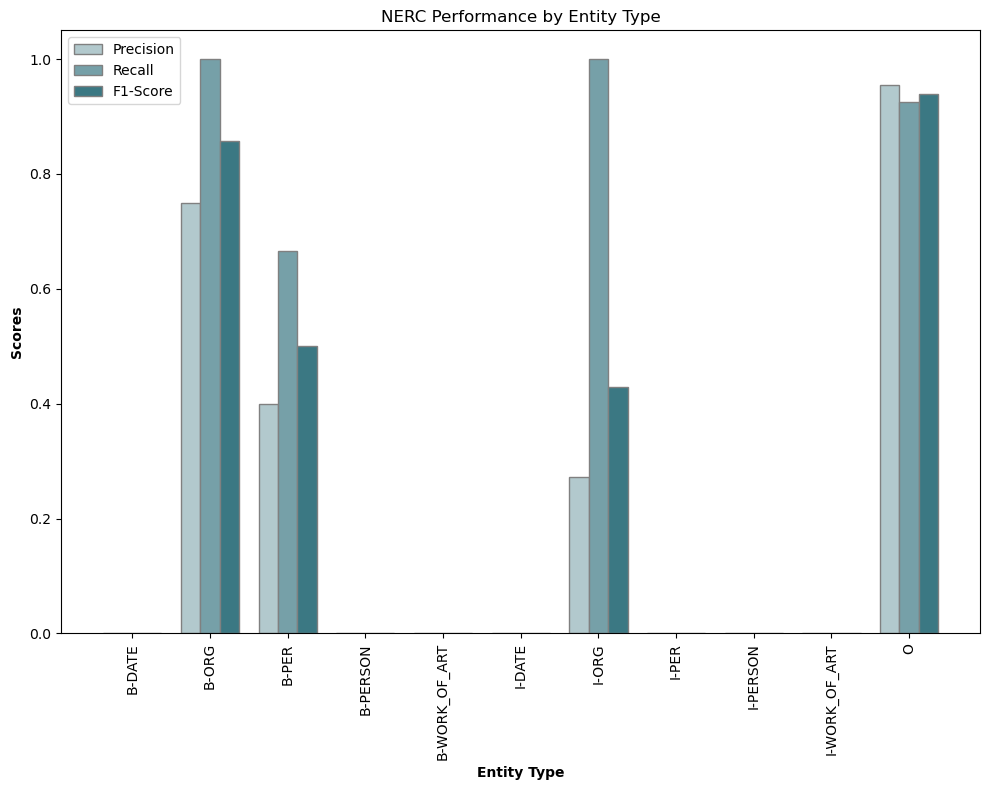

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import numpy as np
import seaborn as sns

# Assuming y_true_flat and y_pred_flat are already defined as in your example
labels = sorted(set(y_true_flat))  # Ensure labels are sorted consistently
report = classification_report(y_true_flat, y_pred_flat, labels=labels, output_dict=True, digits=3, zero_division=0)

# Extracting performance metrics
precision = [report[label]['precision'] for label in labels]
recall = [report[label]['recall'] for label in labels]
f1_score = [report[label]['f1-score'] for label in labels]

barWidth = 0.25

# Set position of bar on X axis
r1 = np.arange(len(precision))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]

cmap = sns.light_palette("#00505E", n_colors=5, reverse=False)

color_precision = cmap[1]  
color_recall = cmap[2]    
color_f1_score = cmap[3]  
plt.figure(figsize=(10,8))
plt.bar(r1, precision, color=color_precision, width=barWidth, edgecolor='grey', label='Precision')
plt.bar(r2, recall, color=color_recall, width=barWidth, edgecolor='grey', label='Recall')
plt.bar(r3, f1_score, color=color_f1_score, width=barWidth, edgecolor='grey', label='F1-Score')

# xticks on the middle of the group bars
plt.xlabel('Entity Type', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(precision))], labels, rotation=90)
plt.ylabel('Scores', fontweight='bold')
plt.title('NERC Performance by Entity Type')

plt.legend()
plt.tight_layout()
plt.show()



## SENTIMENT ANALYSIS

In [9]:
st_test = pd.read_csv('sentiment-topic-test.tsv', delimiter='\t').drop(columns=['sentence id'])

**VADER**

In [10]:
def vader_output_to_label(vader_output):
    compound = vader_output['compound']
    if compound < 0.01:
        return 'negative'
    elif compound > 0.42:
        return 'positive'
    return 'neutral'

vader_model = SentimentIntensityAnalyzer()

vader_pred = [vader_output_to_label(vader_model.polarity_scores(text)) for text in st_test.text.values]
print(classification_report(st_test.sentiment.values, vader_pred, target_names=sa_train.target_names))

              precision    recall  f1-score   support

    negative       0.20      0.25      0.22         4
     neutral       1.00      0.33      0.50         3
    positive       0.25      0.33      0.29         3

    accuracy                           0.30        10
   macro avg       0.48      0.31      0.34        10
weighted avg       0.45      0.30      0.32        10



**Multinomial Naive Bayes**

In [11]:
# Convert the 'data' and 'target' to a DataFrame for easier manipulation
sa_train_df = pd.DataFrame({
    'text': [d.decode('utf-8') for d in sa_train['data']], # Decode each item from bytes to string
    'sentiment': sa_train['target']
})


In [12]:
# Map numeric targets to their corresponding sentiment labels
target_names = sa_train['target_names']
sa_train_df['sentiment'] = sa_train_df['sentiment'].apply(lambda x: target_names[x])


In [13]:
from sklearn.model_selection import train_test_split

X = sa_train_df['text']
y = sa_train_df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=1000)
X_train_vect = vectorizer.fit_transform(X_train)
X_test_vect = vectorizer.transform(X_test)

from sklearn.naive_bayes import MultinomialNB

model = MultinomialNB()
model.fit(X_train_vect, y_train)

from sklearn.metrics import classification_report, accuracy_score

y_pred = model.predict(X_test_vect)




In [14]:
X_test_vect = vectorizer.transform(st_test.text.values)


nb_pred = model.predict(X_test_vect)


print(classification_report(st_test.sentiment.values, nb_pred, target_names=sa_train.target_names))




              precision    recall  f1-score   support

    negative       0.50      0.50      0.50         4
     neutral       0.67      0.67      0.67         3
    positive       0.00      0.00      0.00         3

    accuracy                           0.40        10
   macro avg       0.39      0.39      0.39        10
weighted avg       0.40      0.40      0.40        10



**Fine-Tuning wit DistilBERT**

In [15]:
#Executed on COLAB

**Plotting Sentiment Analysis Performance Comparison**

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

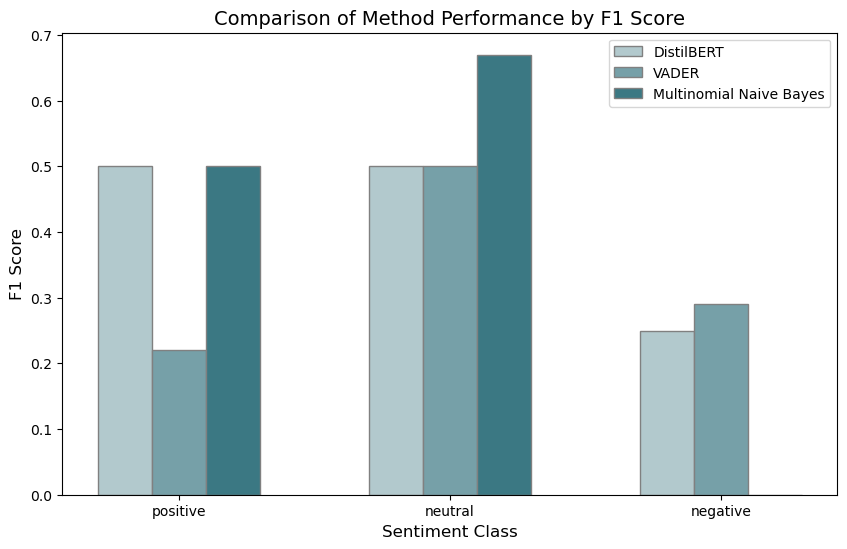

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
# Sample F1-scores for each class by each method
f1_scores = {
    'DistilBERT': {'positive': 0.5, 'neutral': 0.5, 'negative': 0.25},
    'VADER': {'positive': 0.22, 'neutral': 0.5, 'negative': 0.29},
    'Multinomial Naive Bayes': {'positive': 0.5, 'neutral': 0.67, 'negative': 0.0}
}

# Class labels
classes = list(f1_scores['DistilBERT'].keys())

# Positions of the bars on the x-axis
ind = np.arange(len(classes))

# Width of the bars
width = 0.2

# Create a continuous light palette
palette = sns.light_palette("#00505E", n_colors=len(f1_scores) + 2, reverse=False)
bar_colors = palette[1:len(f1_scores) + 1]  # Avoid the darkest color

plt.figure(figsize=(10, 6))

# Plotting with grey edge color
for i, (method, scores) in enumerate(f1_scores.items()):
    f1_values = list(scores.values())
    plt.bar(ind + i * width, f1_values, width, label=method, color=bar_colors[i], edgecolor='grey')

# Adding details
plt.xlabel('Sentiment Class', fontsize=12)
plt.ylabel('F1 Score', fontsize=12)
plt.title('Comparison of Method Performance by F1 Score', fontsize=14)
plt.xticks(ind + width, classes)

plt.legend(loc='upper right', fontsize=10)
plt.tight_layout

## TOPIC CLASSIFICATION

**Data Preparation**

In [17]:
import pandas as pd

# Assuming sports, books, and movies are already loaded DataFrames
sports['topic'] = 'sports'
book['topic'] = 'book'
movie['topic'] = 'movie'

# Concatenate the DataFrames
all_data = pd.concat([sports[['text', 'topic']], book[['text', 'topic']], movie[['text', 'topic']]], ignore_index=True)

# Now, you have a single DataFrame with texts and their corresponding topics


In [18]:
# Assuming sports, books, and movies are your datasets
sports_df = sports[['text', 'topic']]
books_df = book[['text', 'topic']]
movies_df = movie[['text', 'topic']]

# Find the minimum size among the three datasets
min_size = min(len(sports_df), len(books_df), len(movies_df))

# Sample from each dataset to match the minimum size
sports_sample = sports_df.sample(n=min_size, random_state=42)
books_sample = books_df.sample(n=min_size, random_state=42)
movies_sample = movies_df.sample(n=min_size, random_state=42)

# Combine the samples into one balanced dataset
all_data_balanced = pd.concat([sports_sample, books_sample, movies_sample], ignore_index=True)

# Shuffle the dataset to ensure it's mixed well
all_data_balanced = all_data_balanced.sample(frac=1, random_state=42).reset_index(drop=True)


**Sentence Embeddings+SVM**

In [19]:
import torch

In [20]:
!pip install sentence_transformers

   ---------------------------------------- 0.0/163.3 kB ? eta -:--:--
   ------------------------------------- -- 153.6/163.3 kB 4.6 MB/s eta 0:00:01
   ---------------------------------------- 163.3/163.3 kB 3.3 MB/s eta 0:00:00


In [21]:
from sentence_transformers import SentenceTransformer

# Load a pre-trained model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Your sentences
sentences = all_data_balanced['text']

labels = all_data_balanced['topic']

# Generate embeddings
embeddings = model.encode(sentences)

# `embeddings` is a list of vectors, one per sentence


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

c:\Users\arsha\anaconda3\lib\site-packages\huggingface_hub\file_download.py:149: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\arsha\.cache\huggingface\hub\models--sentence-transformers--all-MiniLM-L6-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [22]:
from sklearn.model_selection import train_test_split

# Assuming `all_sentences` is a list of your sentences and `all_labels` are their labels
X_train, X_test, y_train, y_test = train_test_split(embeddings, labels, test_size=0.2, random_state=42)


In [23]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report

# Initialize and train the classifier
clf = SVC(kernel='linear')  
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

        book       0.99      0.99      0.99      1012
       movie       0.97      0.98      0.97       987
      sports       0.98      0.98      0.98      1001

    accuracy                           0.98      3000
   macro avg       0.98      0.98      0.98      3000
weighted avg       0.98      0.98      0.98      3000



In [24]:
# Generate embeddings for your test data
test_embeddings = model.encode(st_test.text.values)

clf_pred = clf.predict(test_embeddings)


# print the classification report for topic classification
print(classification_report(st_test.topic.values, clf_pred, zero_division=0))


              precision    recall  f1-score   support

        book       1.00      0.33      0.50         3
       movie       0.57      1.00      0.73         4
      sports       1.00      0.67      0.80         3

    accuracy                           0.70        10
   macro avg       0.86      0.67      0.68        10
weighted avg       0.83      0.70      0.68        10



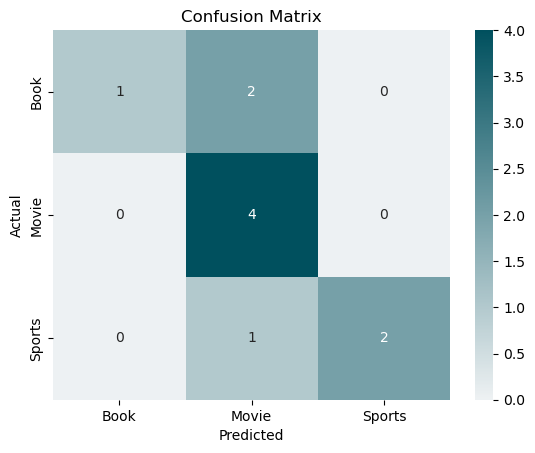

In [25]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming clf_pred are your predictions and st_test.topic.values are true labels
cm = confusion_matrix(st_test.topic.values, clf_pred)

# Create a custom color palette
cmap = sns.light_palette("#00505E", as_cmap=True)

sns.heatmap(cm, annot=True, fmt="d", cmap=cmap, xticklabels=["Book", "Movie", "Sports"], yticklabels=["Book", "Movie", "Sports"])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()
